In [64]:
import nibabel as nib #to read the niftis
from glob import glob #to quicly read the nifti paths
import logging # for printing monai info
import sys # for printing monai info
import monai #for this experiment monai will be the main framework for 2d segmentation
import torch
import time
import os
from monai.transforms import (
    Activations,
    AsChannelFirstD,
    AddChannel,
    AsDiscrete,
    Compose,
    LoadImage,
    RandRotate90,
    RandSpatialCrop,
    ScaleIntensity,
    EnsureType,
    Resized,
    EnsureChannelFirst,
    DivisiblePad,
    NormalizeIntensity
)

from torch.utils.tensorboard import SummaryWriter

from monai.data import (
    ArrayDataset, GridPatchDataset, create_test_image_3d, PatchIter) #Aparently this allow to read direcly a set of niftis
from monai.utils import first
from matplotlib import pyplot as plt
from monai.metrics import DiceMetric

import numpy as np
print(monai.__version__) 
monai.config.print_config()
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
from monai.inferers import sliding_window_inference
from monai.data import DataLoader, decollate_batch

%matplotlib notebook

0.8.0
MONAI version: 0.8.0
Numpy version: 1.20.3
Pytorch version: 1.10.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 714d00dffe6653e21260160666c4c201ab66511b

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.1
scikit-image version: 0.18.1
Pillow version: 8.3.1
Tensorboard version: 2.7.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.11.1
tqdm version: 4.62.2
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.8.0
pandas version: 1.3.2
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.11.3
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



##  Data location

In [65]:
lieu = 'jony_laptop' # 


if lieu =='jony_laptop': # jony_laptop
    synth3d_root = '/home/diffusion/Dropbox/Documents/CHUV/ASAP/FederatedLearning/fedem/data/synthetic_3d/train_noisy/'
    synth3d_val_root = '/home/diffusion/Dropbox/Documents/CHUV/ASAP/FederatedLearning/fedem/data/synthetic_3d/val_noisy/'
    synth3d_test_root = '/home/diffusion/Dropbox/Documents/CHUV/ASAP/FederatedLearning/fedem/data/synthetic_3d/test_noisy/'


## Only spheres

In [66]:
spheres_paths     = sorted(glob(synth3d_root+'*img*.nii.gz'))
lbl_spheres_paths = sorted(glob(synth3d_root+'*seg*.nii.gz'))
print(spheres_paths[-1])

/home/diffusion/Dropbox/Documents/CHUV/ASAP/FederatedLearning/fedem/data/synthetic_3d/train_noisy/sphere_img9.nii.gz


In [67]:
spheres_paths_val     = sorted(glob(synth3d_val_root+'*img*.nii.gz'))
lbl_spheres_paths_val = sorted(glob(synth3d_val_root+'*seg*.nii.gz'))


In [68]:
paths_test     = sorted(glob(synth3d_test_root+'*img*.nii.gz'))
lbl_paths_test = sorted(glob(synth3d_test_root+'*seg*.nii.gz'))

In [84]:
sub_sample_train = True
num=30
if(sub_sample_train):
    spheres_paths = spheres_paths[:num] 
    lbl_spheres_paths = lbl_spheres_paths[:num]

In [85]:
spheres_paths

['/home/diffusion/Dropbox/Documents/CHUV/ASAP/FederatedLearning/fedem/data/synthetic_3d/train_noisy/cubes_img0.nii.gz',
 '/home/diffusion/Dropbox/Documents/CHUV/ASAP/FederatedLearning/fedem/data/synthetic_3d/train_noisy/cubes_img1.nii.gz',
 '/home/diffusion/Dropbox/Documents/CHUV/ASAP/FederatedLearning/fedem/data/synthetic_3d/train_noisy/cubes_img10.nii.gz',
 '/home/diffusion/Dropbox/Documents/CHUV/ASAP/FederatedLearning/fedem/data/synthetic_3d/train_noisy/cubes_img11.nii.gz',
 '/home/diffusion/Dropbox/Documents/CHUV/ASAP/FederatedLearning/fedem/data/synthetic_3d/train_noisy/cubes_img12.nii.gz',
 '/home/diffusion/Dropbox/Documents/CHUV/ASAP/FederatedLearning/fedem/data/synthetic_3d/train_noisy/cubes_img13.nii.gz',
 '/home/diffusion/Dropbox/Documents/CHUV/ASAP/FederatedLearning/fedem/data/synthetic_3d/train_noisy/cubes_img14.nii.gz',
 '/home/diffusion/Dropbox/Documents/CHUV/ASAP/FederatedLearning/fedem/data/synthetic_3d/train_noisy/cubes_img15.nii.gz',
 '/home/diffusion/Dropbox/Document

### Training augmentation and normalization

In [86]:
imtrans = Compose(
    [   LoadImage(image_only=True),
        NormalizeIntensity(),
        DivisiblePad(4),
        AddChannel(),
        #RandSpatialCrop((256, 256,4), random_size=False),
        EnsureType(),
        #Resized
    ]
)

segtrans = Compose(
    [   LoadImage(image_only=True),        
        DivisiblePad(4),
        AddChannel(),
        #RandSpatialCrop((256, 256,4), random_size=False),
        EnsureType(),
        #Resized
    ]
)


val_imtrans  = Compose(
    [   LoadImage(image_only=True),
        NormalizeIntensity(),
        DivisiblePad(4),
        AddChannel(),
        #RandSpatialCrop((256, 256,4), random_size=False),
        EnsureType(),
        #Resized
    ]
)
#val_segtrans = Compose([LoadImage(image_only=True), AddChannel(), EnsureType()])

val_segtrans = Compose(
    [   LoadImage(image_only=True),
        DivisiblePad(4),
        AddChannel(),
       # RandSpatialCrop((256, 256,4), random_size=False),
        EnsureType(),
        #Resized
    ])


## Image read (to change to files)

In [87]:
ds      = ArrayDataset(spheres_paths, imtrans, lbl_spheres_paths, segtrans)

val_ds  = ArrayDataset(spheres_paths_val, val_imtrans, lbl_spheres_paths_val, val_segtrans)

test_ds  = ArrayDataset(paths_test, val_imtrans, lbl_paths_test, val_segtrans)


In [88]:
print(len(set(spheres_paths)), len(set(spheres_paths_val)),len(set(paths_test)))

30 40 40


torch.Size([1, 1, 128, 128, 64]) torch.Size([1, 1, 128, 128, 64])


<IPython.core.display.Javascript object>


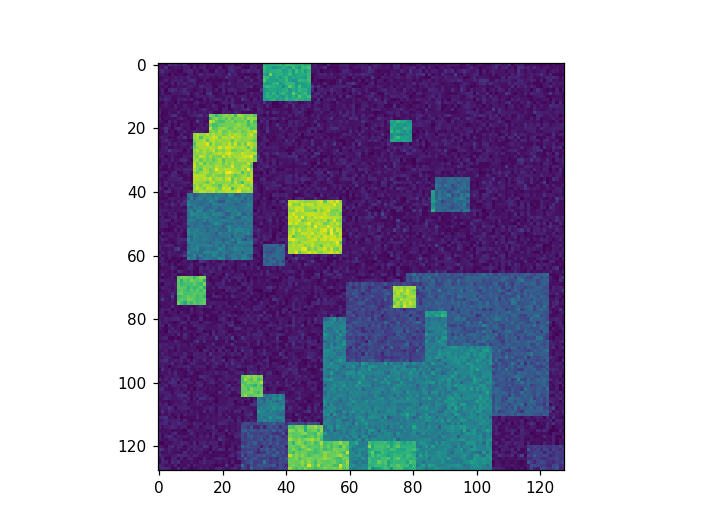

In [89]:
loader = torch.utils.data.DataLoader(ds, batch_size=1, num_workers=1, pin_memory=torch.cuda.is_available())
im, seg = first(loader)
print(im.shape, seg.shape)
plt.imshow(im[0,0,:,:,15])

In [91]:
# create a validation data loader
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=1, num_workers=4, pin_memory=torch.cuda.is_available())
im, seg = first(val_loader)
print(im.shape, seg.shape)
plt.imshow(im[0,0,:,:,15])

torch.Size([1, 1, 128, 128, 64]) torch.Size([1, 1, 128, 128, 64])


In [92]:
# create a test data loader
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=1, num_workers=4, pin_memory=torch.cuda.is_available())
im, seg = first(test_loader)
print(im.shape, seg.shape)
plt.imshow(im[0,0,:,:,15])

torch.Size([1, 1, 128, 128, 64]) torch.Size([1, 1, 128, 128, 64])


In [93]:
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

In [94]:
#post_trans = Compose([EnsureType(), Activations(sigmoid=True), AsDiscrete(threshold_values=True)])
post_trans = Compose([EnsureType(), Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

In [95]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [96]:
# model = monai.networks.nets.UNet(
#     spatial_dims=3,
#     in_channels=1,
#     out_channels=1,
#     channels=(16, 32, 64, 128),
#     strides=(2, 2, 2),
#     #kernel_size = (3,3,2),
#     #dropout = 0.2,
#     num_res_units=2,
# ).to(device)

model = monai.networks.nets.UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64),
    strides=(2, 2),
    #kernel_size = (3,3,2),
    #dropout = 0.2,
    num_res_units=2,
).to(device)

In [97]:
loss_function = monai.losses.DiceLoss(sigmoid=True)

#optimizer = torch.optim.Adam(model.parameters(), 1e-3)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

# start a typical PyTorch training
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
writer = SummaryWriter()

In [98]:
batch_data = next(iter(loader))
inputs, labels = torch.swapaxes(batch_data[0][0], 1, -1).to(device), torch.swapaxes(batch_data[1][0], 1, -1).to(device)
print(batch_data[0][0].shape)
print(inputs.shape,labels.shape)

torch.Size([1, 128, 128, 64])
torch.Size([1, 64, 128, 128]) torch.Size([1, 64, 128, 128])


In [99]:
model(inputs[np.newaxis,:,:,:,:]).shape

torch.Size([1, 1, 64, 128, 128])

In [100]:
model.train()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Se

In [101]:
optimizer.zero_grad()

In [33]:
outputs = model(inputs[np.newaxis,:,:,:,:,])

In [34]:
loss = loss_function(outputs, labels[np.newaxis,:,:,:,:])

In [35]:
loss.backward()

In [36]:
optimizer.step()

<IPython.core.display.Javascript object>


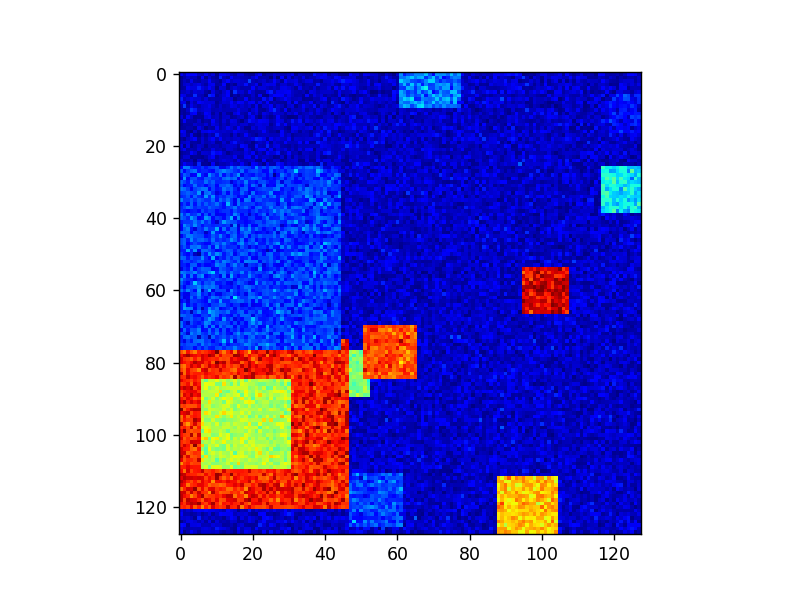

<IPython.core.display.Javascript object>


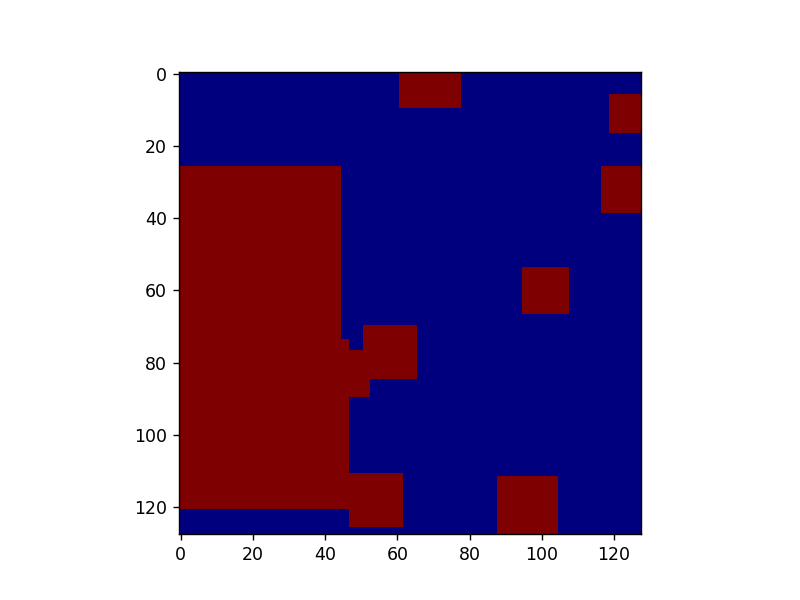

torch.Size([1, 1, 128, 128, 64])
10


In [37]:
for i,batch_data in enumerate(loader):
    if(i==10):
        plt.figure()
        plt.imshow(batch_data[0][0,0,:,:,2],cmap='jet')
        plt.figure()
        plt.imshow(batch_data[1][0,0,:,:,2],cmap='jet')
        print(batch_data[1].shape)
        print(i)

In [102]:
# define inference method
def inference(input):

    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(128, 128, 64),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )


    return _compute(input)


# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = False


epochs = 50
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=2)])

# start a typical PyTorch training
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
writer = SummaryWriter()
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []
best_metrics_epochs_and_time = [[], [], []]
total_start = time.time()
for epoch in range(epochs):
    
    print("-" * epochs)
    print(f"epoch {epoch + 1}/{epochs}")
   
    model.train()
    epoch_loss = 0
    step = 0
    
    for batch_data in loader:
        
        step += 1
        #inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        #Swaping axes to have a batch of Batch_size, Channels, width and height
        inputs, labels = torch.swapaxes(batch_data[0][0], 1, -1).to(device), torch.swapaxes(batch_data[1][0], 1, -1).to(device)

        #print(batch_data[0][0].shape)
        #print(inputs.shape)
        
        optimizer.zero_grad()
        
        #outputs = model(inputs[np.newaxis,:,:,:,:])
        outputs = model(inputs[np.newaxis,:,:,:,:,])
        
        loss = loss_function(outputs, labels[np.newaxis,:,:,:,:])
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_len = len(loader) // loader.batch_size
        
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
        
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    
    if (epoch ) % val_interval == 0:
        model.eval()
        with torch.no_grad():

            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data[0].to(device),
                    val_data[1].to(device),
                )
                val_outputs = inference(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_tc = metric_batch[0].item()
#             metric_values_tc.append(metric_tc)
#             metric_wt = metric_batch[1].item()
#             metric_values_wt.append(metric_wt)
#             metric_et = metric_batch[2].item()
#             metric_values_et.append(metric_et)
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                
                torch.save(model.state_dict(), "best_metric_model_segmentation2d_array.pth")
                print("saved new best metric model")
            print(
                "current epoch: {} current mean dice: {:.4f} best mean dice: {:.4f} at epoch {}".format(
                    epoch + 1, metric, best_metric, best_metric_epoch
                )
            )
            writer.add_scalar("val_mean_dice", metric, epoch + 1)

total_time = time.time() - total_start

--------------------------------------------------
epoch 1/50
1/30, train_loss: 0.5616
2/30, train_loss: 0.5700
3/30, train_loss: 0.4850
4/30, train_loss: 0.5750
5/30, train_loss: 0.4705
6/30, train_loss: 0.4598
7/30, train_loss: 0.4926
8/30, train_loss: 0.4100
9/30, train_loss: 0.5550
10/30, train_loss: 0.4090
11/30, train_loss: 0.4242
12/30, train_loss: 0.3422
13/30, train_loss: 0.3860
14/30, train_loss: 0.4035
15/30, train_loss: 0.3680
16/30, train_loss: 0.4772
17/30, train_loss: 0.5528
18/30, train_loss: 0.3807
19/30, train_loss: 0.4321
20/30, train_loss: 0.4639
21/30, train_loss: 0.5322
22/30, train_loss: 0.3300
23/30, train_loss: 0.5076
24/30, train_loss: 0.3838
25/30, train_loss: 0.4124
26/30, train_loss: 0.3136
27/30, train_loss: 0.4412
28/30, train_loss: 0.4119
29/30, train_loss: 0.3608
30/30, train_loss: 0.3033
epoch 1 average loss: 0.4405
saved new best metric model
current epoch: 1 current mean dice: 0.8682 best mean dice: 0.8682 at epoch 1
---------------------------------

1/30, train_loss: 0.0846
2/30, train_loss: 0.1085
3/30, train_loss: 0.0570
4/30, train_loss: 0.1472
5/30, train_loss: 0.0623
6/30, train_loss: 0.0596
7/30, train_loss: 0.0833
8/30, train_loss: 0.0409
9/30, train_loss: 0.1710
10/30, train_loss: 0.0450
11/30, train_loss: 0.0537
12/30, train_loss: 0.0591
13/30, train_loss: 0.0442
14/30, train_loss: 0.0470
15/30, train_loss: 0.0384
16/30, train_loss: 0.1249
17/30, train_loss: 0.2261
18/30, train_loss: 0.0485
19/30, train_loss: 0.0878
20/30, train_loss: 0.1321
21/30, train_loss: 0.2267
22/30, train_loss: 0.0368
23/30, train_loss: 0.2066
24/30, train_loss: 0.0664
25/30, train_loss: 0.0973
26/30, train_loss: 0.0344
27/30, train_loss: 0.1328
28/30, train_loss: 0.1076
29/30, train_loss: 0.0628
30/30, train_loss: 0.0345
epoch 10 average loss: 0.0909
--------------------------------------------------
epoch 11/50
1/30, train_loss: 0.0693
2/30, train_loss: 0.0906
3/30, train_loss: 0.0455
4/30, train_loss: 0.1258
5/30, train_loss: 0.0493
6/30, train

1/30, train_loss: 0.0199
2/30, train_loss: 0.0267
3/30, train_loss: 0.0126
4/30, train_loss: 0.0423
5/30, train_loss: 0.0136
6/30, train_loss: 0.0135
7/30, train_loss: 0.0183
8/30, train_loss: 0.0083
9/30, train_loss: 0.0545
10/30, train_loss: 0.0105
11/30, train_loss: 0.0116
12/30, train_loss: 0.0225
13/30, train_loss: 0.0120
14/30, train_loss: 0.0096
15/30, train_loss: 0.0095
16/30, train_loss: 0.0351
17/30, train_loss: 0.0829
18/30, train_loss: 0.0132
19/30, train_loss: 0.0207
20/30, train_loss: 0.0376
21/30, train_loss: 0.0854
22/30, train_loss: 0.0101
23/30, train_loss: 0.0756
24/30, train_loss: 0.0148
25/30, train_loss: 0.0248
26/30, train_loss: 0.0090
27/30, train_loss: 0.0389
28/30, train_loss: 0.0292
29/30, train_loss: 0.0150
30/30, train_loss: 0.0090
epoch 19 average loss: 0.0262
saved new best metric model
current epoch: 19 current mean dice: 0.9550 best mean dice: 0.9550 at epoch 19
--------------------------------------------------
epoch 20/50
1/30, train_loss: 0.0183
2/30

1/30, train_loss: 0.0081
2/30, train_loss: 0.0110
3/30, train_loss: 0.0054
4/30, train_loss: 0.0184
5/30, train_loss: 0.0058
6/30, train_loss: 0.0060
7/30, train_loss: 0.0073
8/30, train_loss: 0.0039
9/30, train_loss: 0.0239
10/30, train_loss: 0.0051
11/30, train_loss: 0.0052
12/30, train_loss: 0.0127
13/30, train_loss: 0.0062
14/30, train_loss: 0.0040
15/30, train_loss: 0.0050
16/30, train_loss: 0.0152
17/30, train_loss: 0.0396
18/30, train_loss: 0.0063
19/30, train_loss: 0.0083
20/30, train_loss: 0.0163
21/30, train_loss: 0.0419
22/30, train_loss: 0.0056
23/30, train_loss: 0.0362
24/30, train_loss: 0.0059
25/30, train_loss: 0.0104
26/30, train_loss: 0.0046
27/30, train_loss: 0.0167
28/30, train_loss: 0.0128
29/30, train_loss: 0.0063
30/30, train_loss: 0.0043
epoch 28 average loss: 0.0119
--------------------------------------------------
epoch 29/50
1/30, train_loss: 0.0077
2/30, train_loss: 0.0106
3/30, train_loss: 0.0051
4/30, train_loss: 0.0172
5/30, train_loss: 0.0055
6/30, train

2/30, train_loss: 0.0062
3/30, train_loss: 0.0033
4/30, train_loss: 0.0103
5/30, train_loss: 0.0035
6/30, train_loss: 0.0035
7/30, train_loss: 0.0039
8/30, train_loss: 0.0022
9/30, train_loss: 0.0136
10/30, train_loss: 0.0030
11/30, train_loss: 0.0029
12/30, train_loss: 0.0092
13/30, train_loss: 0.0040
14/30, train_loss: 0.0024
15/30, train_loss: 0.0030
16/30, train_loss: 0.0084
17/30, train_loss: 0.0230
18/30, train_loss: 0.0041
19/30, train_loss: 0.0045
20/30, train_loss: 0.0092
21/30, train_loss: 0.0243
22/30, train_loss: 0.0036
23/30, train_loss: 0.0213
24/30, train_loss: 0.0034
25/30, train_loss: 0.0057
26/30, train_loss: 0.0032
27/30, train_loss: 0.0091
28/30, train_loss: 0.0072
29/30, train_loss: 0.0035
30/30, train_loss: 0.0030
epoch 37 average loss: 0.0070
current epoch: 37 current mean dice: 0.9579 best mean dice: 0.9629 at epoch 33
--------------------------------------------------
epoch 38/50
1/30, train_loss: 0.0044
2/30, train_loss: 0.0059
3/30, train_loss: 0.0032
4/30, t

3/30, train_loss: 0.0021
4/30, train_loss: 0.0065
5/30, train_loss: 0.0023
6/30, train_loss: 0.0022
7/30, train_loss: 0.0023
8/30, train_loss: 0.0014
9/30, train_loss: 0.0085
10/30, train_loss: 0.0020
11/30, train_loss: 0.0018
12/30, train_loss: 0.0062
13/30, train_loss: 0.0026
14/30, train_loss: 0.0014
15/30, train_loss: 0.0021
16/30, train_loss: 0.0052
17/30, train_loss: 0.0146
18/30, train_loss: 0.0025
19/30, train_loss: 0.0025
20/30, train_loss: 0.0054
21/30, train_loss: 0.0154
22/30, train_loss: 0.0023
23/30, train_loss: 0.0132
24/30, train_loss: 0.0018
25/30, train_loss: 0.0034
26/30, train_loss: 0.0021
27/30, train_loss: 0.0055
28/30, train_loss: 0.0044
29/30, train_loss: 0.0020
30/30, train_loss: 0.0018
epoch 46 average loss: 0.0043
--------------------------------------------------
epoch 47/50
1/30, train_loss: 0.0027
2/30, train_loss: 0.0036
3/30, train_loss: 0.0020
4/30, train_loss: 0.0062
5/30, train_loss: 0.0021
6/30, train_loss: 0.0021
7/30, train_loss: 0.0022
8/30, train

In [103]:
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: {total_time}.")

train completed, best_metric: 0.9641 at epoch: 49, total time: 760.64972615242.


<IPython.core.display.Javascript object>


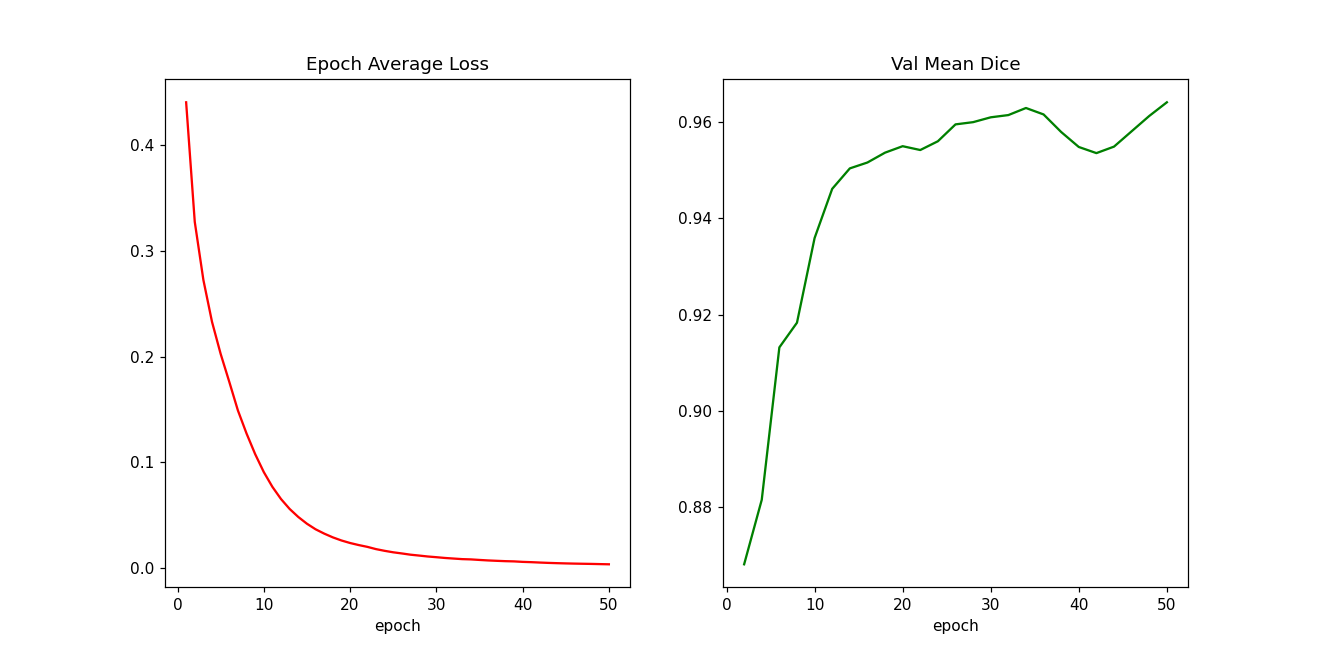

In [104]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()



<IPython.core.display.Javascript object>


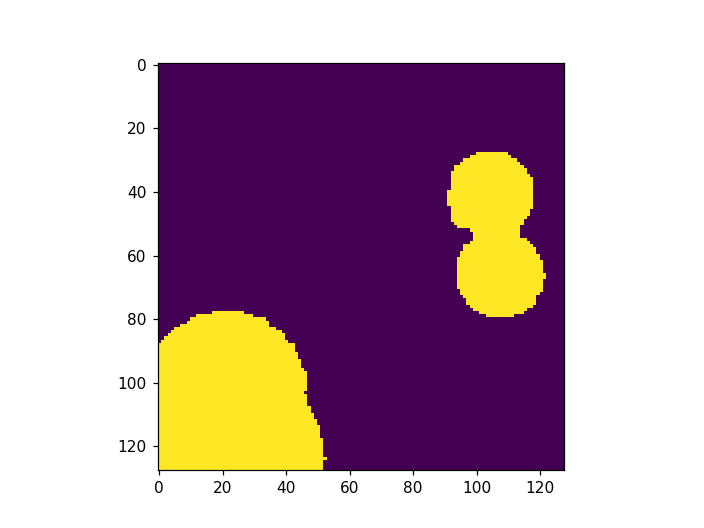

In [105]:
val_outputs = inference(val_inputs)
val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
plt.figure()
plt.imshow(val_outputs[0][0][:,:,20].cpu().numpy())

<IPython.core.display.Javascript object>


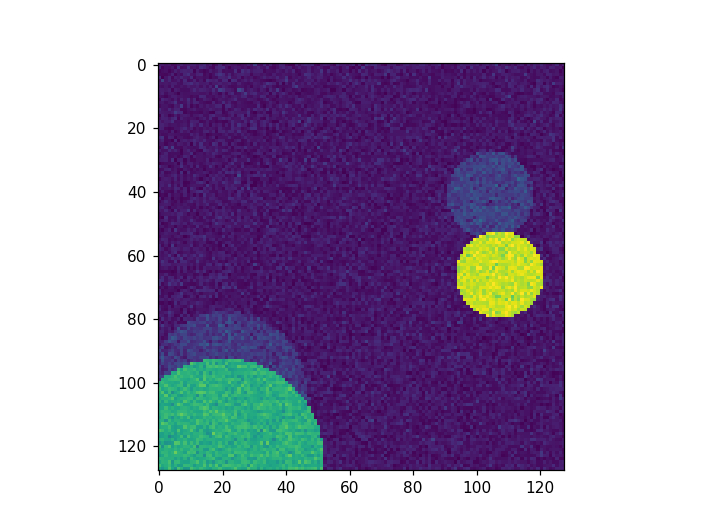

In [106]:
plt.figure()
plt.imshow(val_inputs[0][0][:,:,20].cpu().numpy())

<IPython.core.display.Javascript object>


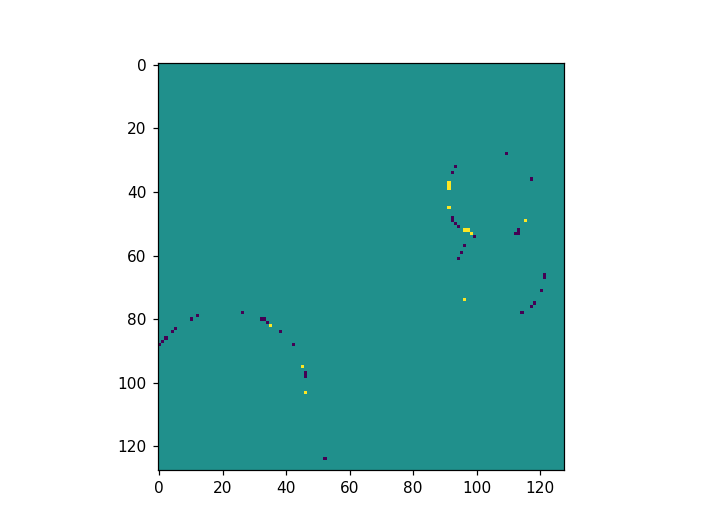

In [107]:
plt.figure()
plt.imshow(val_labels[0][0][:,:,20].cpu().numpy() - val_outputs[0][0][:,:,20].cpu().numpy())

<IPython.core.display.Javascript object>


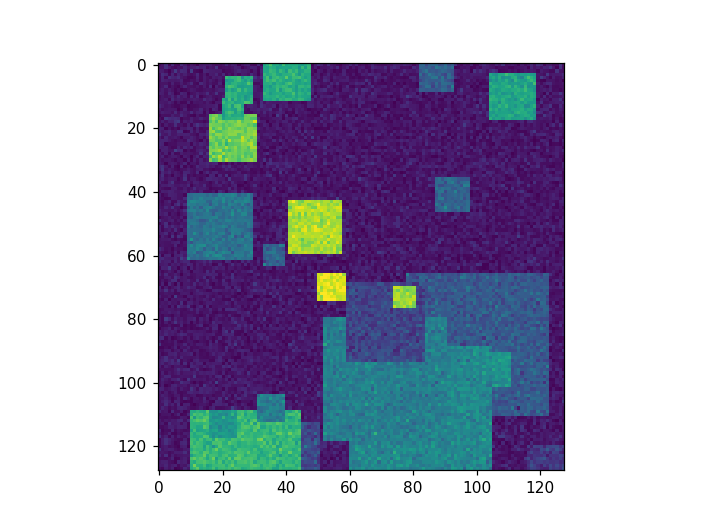

In [108]:
test_data = first(test_loader)
test_inputs, test_labels = (
    test_data[0].to(device),
    test_data[1].to(device),
)
test_outputs = inference(test_inputs)
test_outputs = [post_trans(i) for i in decollate_batch(test_outputs)]
plt.figure()
plt.imshow(test_inputs[0][0][:,:,20].cpu().numpy())



<IPython.core.display.Javascript object>


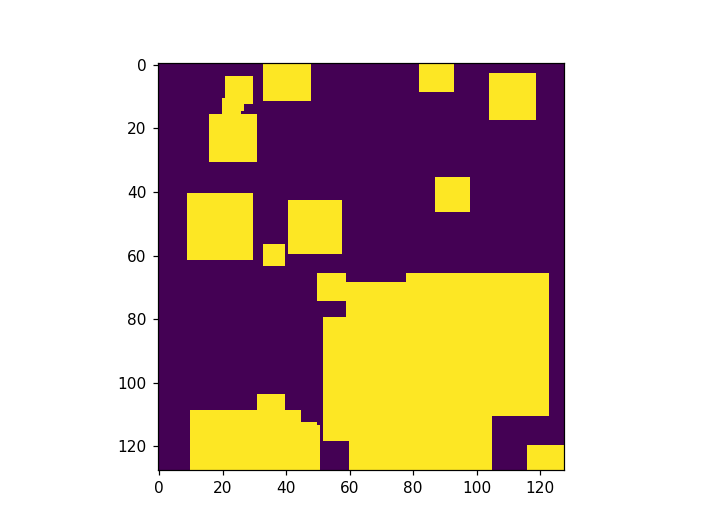

In [109]:
plt.figure()
plt.imshow(test_outputs[0][0][:,:,20].cpu().numpy())

<IPython.core.display.Javascript object>


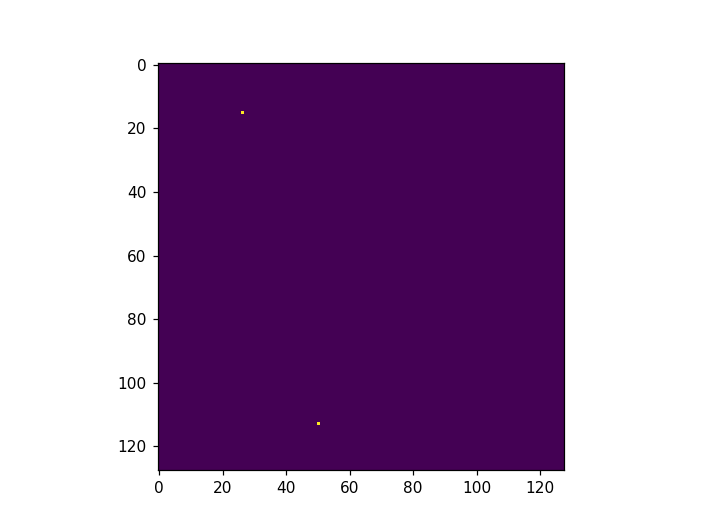

In [110]:
plt.figure()
plt.imshow(test_labels[0][0][:,:,20].cpu().numpy() - test_outputs[0][0][:,:,20].cpu().numpy())